In [1]:
!which python
!whoami 
!hostname
!pwd

/home/farshed.abdukhakimov/miniconda3/envs/main/bin/python
farshed.abdukhakimov
srv-01
/home/farshed.abdukhakimov/projects/twin-polyak/experiments


In [93]:
%load_ext autoreload
%autoreload 2

import os
import datetime
import time
from collections import defaultdict
import pickle
import csv

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import numpy as np

import matplotlib.pyplot as plt

import utils
from utils import moving_average
from solve_binary_libsvm import solve_binary_libsvm

import sklearn
import sklearn.datasets
from sklearn.model_selection import train_test_split

import scipy
import svmlight_loader

import lightning as L
import torchmetrics

from dotenv import load_dotenv
load_dotenv()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


True

In [94]:
device = torch.device('cpu')
device

device(type='cpu')

In [95]:
data_dir: str = os.getenv("LIBSVM_DIR")
dataset = sklearn.datasets.fetch_rcv1(data_home=data_dir, download_if_missing=True, random_state=0)
data, target = dataset.data, dataset.target

data.shape, target.shape

((804414, 47236), (804414, 103))

In [11]:
class RCV1Dataset(Dataset):
    def __init__(self, X_sparse, y_array):
        self.X = X_sparse
        self.y = y_array

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class RCV1DataModule(L.LightningDataModule):
    
    def __init__(self, data_dir: str = os.getenv("LIBSVM_DIR"), batch_size: int = 32):
        super().__init__()
        
        dataset = sklearn.datasets.fetch_rcv1(data_home=data_dir, download_if_missing=True, random_state=0)
        data, target = dataset.data, dataset.target
        self.train_data, self.val_data, self.train_target, self.val_target = train_test_split(data, target, test_size=0.33, random_state=0)

        self.batch_size = batch_size
        self.num_features = data.shape[1]
        self.num_labels = target.shape[1]

    def setup(self, stage: str):
        
        if stage  == 'fit':
            self.train_dataset = RCV1Dataset(self.train_data, self.train_target)
            self.val_dataset = RCV1Dataset(self.val_data, self.val_target)
        if stage == 'test':
            self.val_dataset = RCV1Dataset(self.val_data, self.val_target)
        if stage == 'predict':
            self.val_dataset = RCV1Dataset(self.val_data, self.val_target)
            
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, collate_fn=self._sparse_collate, num_workers=4, shuffle=True)
    
    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, collate_fn=self._sparse_collate, num_workers=4, shuffle=False)

    def test_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, collate_fn=self._sparse_collate, num_workers=4, shuffle=False)
    
    
    def _sparse_coo_to_tensor(self, coo):
        values = coo.data
        indices = np.vstack((coo.row, coo.col))
        shape = coo.shape
        
        i = torch.LongTensor(indices)
        v = torch.FloatTensor(values)
        s = torch.Size(shape)
        
        return torch.sparse_coo_tensor(i, v, s)

    def _sparse_collate(self, batch):
        xs, ys = zip(*batch)
        
        xs = scipy.sparse.vstack(xs).tocoo()
        xs = self._sparse_coo_to_tensor(xs)
        
        ys = scipy.sparse.vstack(ys).tocoo()
        ys = self._sparse_coo_to_tensor(ys)
        
        return xs, ys



In [12]:
data_dir: str = os.getenv("LIBSVM_DIR")

dataset = sklearn.datasets.fetch_rcv1(data_home=data_dir, download_if_missing=True, random_state=0)
data, target = dataset.data, dataset.target
train_data, val_data, train_target, val_target = train_test_split(data, target, test_size=0.33, random_state=0)


target.shape[1]

103

In [53]:
import torchmetrics.classification

optimizers_dict = {
    'Adam': torch.optim.Adam,
}


class LinearModel(nn.Module):
    
    def __init__(self, input_dim: int, output_dim: int):
        super().__init__()
        self.linear = nn.Linear(in_features=input_dim, out_features=output_dim)
        
    def forward(self, x):
        return self.linear(x)

class RCV1Classifier(L.LightningModule):
    
    def __init__(self, input_dim: int, num_labels: int, config: dict):
        super().__init__()
        
        self.save_hyperparameters(
            {
                'dataset': 'RCV1',
                'task': 'multi-label-classification',
                'model': 'linear',
                'config': config,
            }
        )
        
        self.model = LinearModel(input_dim=input_dim, output_dim=num_labels)
        self.loss_fn = nn.BCEWithLogitsLoss()
        
        self.val_acc = torchmetrics.classification.MultilabelAccuracy(num_labels=num_labels)
        
    def training_step(self, batch):
        x, y = batch
        x = x.to_dense()
        y = y.to_dense()
        
        logits = self.model(x)
        loss = self.loss_fn(logits, y)
        
        self.log('train_loss', loss, on_epoch=True)
        
        return loss
        
    def validation_step(self, batch):
        x, y = batch
        x = x.to_dense()
        y = y.to_dense()
        
        logits = self.model(x)
        loss = self.loss_fn(logits, y)
        self.val_acc(logits, y)
        
        self.log('val_loss', loss, on_epoch=True)
        self.log('val_acc', self.val_acc, on_epoch=True)
        
        
    def configure_optimizers(self):
        optimizer = self.hparams['config']['optimizer']
        optimizer_hparams = self.hparams['config']['optimizer_hparams']
        optimizer = optimizers_dict[optimizer](self.model.parameters(), **optimizer_hparams)
        return optimizer
        

In [62]:
from lightning import Callback
import uuid
import json

class DBLogger(Callback):
    
    def __init__(self, db_path: str = 'experiments_db.csv'):
        super().__init__()
        self.db_path: str = db_path
        
        self.run_id = str(uuid.uuid4())
        self.fields: list = ['run_id', 'dataset', 'task', 'model', 'optimizer', 'optimizer_hparams', 'metrics_path', 'start_time', 'end_time']
        
        if not os.path.exists(self.db_path):
            with open(self.db_path, 'w', newline='') as f:
                writer = csv.DictWriter(f, fieldnames=self.fields)
                writer.writeheader()

    def on_fit_start(self, trainer, pl_module):
        self.start_time = datetime.datetime.now().isoformat()
        
    def on_fit_end(self, trainer, pl_module):
        end_time = datetime.datetime.now().isoformat()
        
        hparams = trainer.model.hparams
        config = hparams['config']

        metrics_path = trainer.logger[0].log_dir if isinstance(trainer.logger, list) else trainer.logger.log_dir
        
        with open(self.db_path, 'a', newline='') as f:
            writer = csv.DictWriter(f, fieldnames=self.fields)
            writer.writerow({
                'run_id': self.run_id,
                'start_time': self.start_time,
                'end_time': end_time,
                'dataset': hparams.get('dataset', 'unknown'),
                'task': hparams.get('task', 'unknown'),
                'model': hparams.get('model', 'unknown'),
                'optimizer': config.get('optimizer', 'unknown'),
                'optimizer_hparams': json.dumps(config.get('optimizer_hparams', 'unknown')),
                'metrics_path': metrics_path,
            })
        

In [ ]:
from lightning.pytorch import Trainer, seed_everything, loggers

seed_everything(0, workers=True)

data_module = RCV1DataModule(batch_size=512)
data_module.setup('fit')

print(data_module.num_features)
print(data_module.num_labels)

config = {
    'optimizer': 'Adam',
    'optimizer_hparams': {
        'lr': 2e-3,
    },
}

model = RCV1Classifier(input_dim=data_module.num_features, 
                       num_labels=data_module.num_labels,
                       config=config)

db_logger_callback = DBLogger()
csv_logger = loggers.CSVLogger(
    save_dir=f"logs/{model.hparams['dataset']}",
    version=datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    )

trainer = L.Trainer(max_epochs=1, logger=[csv_logger], callbacks=[db_logger_callback])

# trainer.validate(model=model, dataloaders=data_module.val_dataloader())
# trainer.validate(model=model, dataloaders=data_module.train_dataloader())
trainer.fit(model=model, datamodule=data_module)

Seed set to 0
Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name    | Type               | Params | Mode 
-------------------------------------------------------
0 | model   | LinearModel        | 4.9 M  | train
1 | loss_fn | BCEWithLogitsLoss  | 0      | train
2 | val_acc | MultilabelAccuracy | 0      | train
-------------------------------------------------------
4.9 M     Trainable params
0         Non-trainable params
4.9 M

47236
103


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=1` reached.


In [49]:
trainer.logger.log_hyperparams({'a': 1})

In [12]:
num_labels = len(dataset.target_names)
input_dim = data.shape[1]

model = LinearModel(input_dim=input_dim, output_dim=num_labels).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(10):
    
    train_loss = 0.0
    for x, y in train_dataloader:

        x = x.to_dense().to(device) 
        y = y.to_dense().to(device)
        
        logits = model(x)
        loss = criterion(logits, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * x.size(0)
        
    avg_loss = train_loss / len(train_dataloader.dataset)
    
    print(f"{avg_loss=}")

avg_loss=0.18499741653636154
avg_loss=0.06482186386018932
avg_loss=0.04606754152457511
avg_loss=0.03726604556320695


KeyboardInterrupt: 

In [ ]:
def plotter(histories, labels, colors=None, linestyles=None, 
            linewidths=None, markers=None, markeredgecolor=None, markersize=8,
            alphas=None, f_star=None, suptitle=None, prefix="train",
            x_labels=None, y_labels=None,
            threshold=1e-10, xlims=None, apply_ma=True,
            tight_layout=True, filename=None):
    
    fig, ax = plt.subplots(1, 4, figsize=(16, 4))
    if suptitle is not None:
        fig.suptitle(suptitle, fontsize=16)
        
    if colors is None:
        colors = list(plt.cm.colors.XKCD_COLORS.keys())
        np.random.shuffle(colors)
        colors = list(plt.cm.colors.BASE_COLORS) + colors
        
    if linestyles is None:
        linestyles = ["-" for x in histories]
    
    if linewidths is None:
        linewidths = [1.5 for x in histories]
        
    if markers is None:
        markers = [" " for x in histories]
    
    if alphas is None:
        alphas = [1.0 for x in histories]

    ma_factor = lambda x: x // 20 if apply_ma else 0
        
    for history, label, c, ls, lw, m, alpha in zip(histories, labels, colors, linestyles, linewidths, markers, alphas):
        if not f_star:
            f_suboptim = history[f"{prefix}/loss"]
        else:
            f_suboptim = history[f"{prefix}/loss"] - f_star
        
        f_suboptim = moving_average(f_suboptim, ma_factor(len(f_suboptim)))

        try:
            markevery = [0, ] + [x + np.random.randint(0, 5) for x in range(0, len(history[f"{prefix}/loss"]) - 5, len(history[f"{prefix}/loss"]) // 10)]
        except:
            markevery = []
        
        ax[0].semilogy(f_suboptim, linestyle=ls, linewidth=lw, color=c, markevery=markevery, marker=m, markeredgecolor=markeredgecolor, markersize=markersize)
        
        res = history[f"{prefix}/grad_norm_sq"]
        res = moving_average(res, ma_factor(len(res)))
        ax[1].semilogy(res, linestyle=ls, linewidth=lw, color=c, label=label, markevery=markevery, marker=m, markeredgecolor=markeredgecolor, markersize=markersize)
        
        ax[2].plot(history[f"test/acc"], linestyle=ls, linewidth=lw, color=c, markevery=markevery, marker=m, markeredgecolor=markeredgecolor, markersize=markersize)
        
        try:
            markevery = [0, ] + [x + np.random.randint(0, 5) for x in range(0, len(history["lr"]) - 5, len(history["lr"]) // 5)]
        except:
            markevery = []
        
        res = history["lr"]
        res = moving_average(res, ma_factor(len(res)))
        if alpha != 1.0:
            ax[3].semilogy(res, linestyle=ls, linewidth=lw, color=c, alpha=alpha)
            ax[3].semilogy(moving_average(res, ma_factor(len(f_suboptim))), linestyle=ls, linewidth=lw, color=c, alpha=1.0, markevery=markevery, marker=m, markeredgecolor=markeredgecolor, markersize=markersize)
        else:
            ax[3].semilogy(res, linestyle=ls, linewidth=lw, color=c, markevery=markevery, marker=m, markeredgecolor=markeredgecolor, markersize=markersize)

    if f_star == 0.0:
        ax[0].set_ylabel(r"$f(x_k)$")
        ax[1].set_ylabel(r"$\| \nabla f(x_k) \|^2$")
    else:
        ax[0].set_ylabel(r"$f(x_k) - f^*$")
        ax[1].set_ylabel(r"$\| \nabla f(x_k) \|^2$")
        
    ax[2].set_ylabel("Test Accuracy")
    ax[3].set_ylabel("step-size")
    
    ax[0].set_xlabel("Epochs")
    ax[1].set_xlabel("Epochs")
    ax[2].set_xlabel("Epochs")
    ax[3].set_xlabel("Steps")
    
    # ax[3].tick_params(axis='x', rotation=45)


    if xlims is not None:
        ax[1].set_xlim(right=xlims[1])
    
    fig.legend()

    ax[0].grid()
    ax[1].grid()
    ax[2].grid()
    ax[3].grid()

    if tight_layout:
        fig.tight_layout()
        
    if filename is not None:
        directory = "plots/" + datetime.datetime.today().strftime("%d-%m-%Y")
        if not os.path.exists(directory):
            os.makedirs(directory)
        fig.savefig(directory + "/" + filename)
    else:
        fig.show()

In [64]:
def train_loop(dataset: list[np.ndarray], 
               batch_size: int, 
               n_epochs: int,
               optimizer: BaseOptimizer,
               seed: int = 0,
               **optimizer_kwargs) -> dict: 

    np.random.seed(seed)

    train_data, train_target, test_data, test_target = dataset
    
    # params = np.zeros(train_data.shape[1])
    params = np.random.randn(train_data.shape[1])
    
    optim = optimizer(params, **optimizer_kwargs)

    # oracle 
    loss_function = LogisticRegressionLoss(lmd=0.0)
    
    # logging 
    history = defaultdict(list)

    indices = np.arange(train_data.shape[0])
    
    # Train Evaluation 
    loss, grad, acc = loss_function.func_grad_acc(params, train_data, train_target)
    g_norm_sq = np.linalg.norm(grad)**2
    history["train/loss"].append(loss)
    history["train/acc"].append(acc)
    history["train/grad_norm_sq"].append(g_norm_sq)

    # Test Evaluation 
    loss, grad, acc = loss_function.func_grad_acc(params, test_data, test_target)
    g_norm_sq = np.linalg.norm(grad)**2
    history["test/loss"].append(loss)
    history["test/acc"].append(acc)
    history["test/grad_norm_sq"].append(g_norm_sq)
    
    # batch_size = int(train_data.shape[0] * 0.9)
    
    for epoch in range(n_epochs):
        
        # Training 
        if batch_size != train_data.shape[0]: # If full batch then don't shuffle indices
            np.random.shuffle(indices)

        for idx in range(train_data.shape[0]//batch_size):

            batch_indices = indices[idx*batch_size:(idx+1)*batch_size]
            batch_data = train_data[batch_indices]
            batch_target = train_target[batch_indices] 
        
            train_loss, train_grad, train_acc = loss_function.func_grad_acc(params, batch_data, batch_target)

            if optim.__class__.__name__ == "SLS":
                def closure(params):
                    return loss_function.func(params, batch_data, batch_target)
                optim.step(loss=train_loss, grad=train_grad, closure=closure)
            else:
                optim.step(loss=train_loss, grad=train_grad)
            
            g_norm_sq = np.linalg.norm(train_grad)**2
            history["train/batch/loss"].append(train_loss)
            history["train/batch/acc"].append(train_acc)
            history["train/batch/grad_norm_sq"].append(g_norm_sq)  

            history["lr"].append(optim.lr)
            
            a = (2 * (loss - train_f_star)) / (np.square(np.linalg.norm(grad)))
            history["true_polyak"].append(a)    

        # if (epoch + 1) % 20 == 0:
        #     batch_size = int(train_data.shape[0] * 0.1)
        
        # if (epoch + 1) % 50 == 0:
        #     if optim.betas[0] < 0.8 and optim.betas[1] < 0.8:
        #         optim.betas = (optim.betas[0] + 0.2, optim.betas[1] + 0.2)
        #     else:
        #         optim.betas = (0.9, 0.9)
                
        #     print(epoch, optim.betas)

        # Train Evaluation 
        loss, grad, acc = loss_function.func_grad_acc(params, train_data, train_target)
        g_norm_sq = np.linalg.norm(grad)**2
        history["train/loss"].append(loss)
        history["train/acc"].append(acc)
        history["train/grad_norm_sq"].append(g_norm_sq)
        


        # Test Evaluation 
        loss, grad, acc = loss_function.func_grad_acc(params, test_data, test_target)
        g_norm_sq = np.linalg.norm(grad)**2
        history["test/loss"].append(loss)
        history["test/acc"].append(acc)
        history["test/grad_norm_sq"].append(g_norm_sq)

    return history

In [70]:
def twin_polyak(dataset: list[np.ndarray], 
               batch_size: int, 
               n_epochs: int,
               seed: int = 0,
               eps: float = 0.0,
               ) -> dict: 
    
    np.random.seed(seed)

    train_data, train_target, test_data, test_target = dataset

    # parameters
    params_x = np.random.randn(train_data.shape[1])
    params_y = np.random.randn(train_data.shape[1])

    # oracle 
    loss_function = LogisticRegressionLoss(lmd=0.0)
    
    # logging 
    history = defaultdict(list)

    indices = np.arange(train_data.shape[0])
    
    # Train Evaluation 
    loss, grad, acc = loss_function.func_grad_acc(params_x, train_data, train_target)
    g_norm_sq = np.linalg.norm(grad)**2
    history["train/loss"].append(loss)
    history["train/acc"].append(acc)
    history["train/grad_norm_sq"].append(g_norm_sq)
    
    # Test Evaluation 
    loss, grad, acc = loss_function.func_grad_acc(params_x, test_data, test_target)
    g_norm_sq = np.linalg.norm(grad)**2
    history["test/loss"].append(loss)
    history["test/acc"].append(acc)
    history["test/grad_norm_sq"].append(g_norm_sq)

    for epoch in range(n_epochs):
    
        # Training 
        if batch_size != train_data.shape[0]:
            np.random.shuffle(indices)

        for idx in range(train_data.shape[0]//batch_size):
            batch_indices = indices[idx*batch_size:(idx+1)*batch_size]
            
            batch_data = train_data[batch_indices]
            batch_target = train_target[batch_indices] 
            
            loss_x, grad_x, acc_x = loss_function.func_grad_acc(params_x, batch_data, batch_target)
            loss_y, grad_y, acc_y  = loss_function.func_grad_acc(params_y, batch_data, batch_target)
            
            lr_x = (loss_x - loss_y) / (0.5 * np.square(np.linalg.norm(grad_x)) + eps) 
            lr_y = (loss_y - loss_x) / (0.5 * np.square(np.linalg.norm(grad_y)) + eps) 
            # Optimization step
            if loss_x > loss_y:
                params_x -= lr_x * grad_x
                lr = lr_x
            else:
                params_y -= lr_y * grad_y
                lr = lr_y
            
            history["bound_c"].append( np.abs(loss_x - loss_y) / (np.maximum(loss_x, loss_y) - train_f_star))
            history["bound_d"].append( (loss_y - train_f_star) / (loss_x - train_f_star) )
            history["bound_dd"].append( (np.minimum(loss_x, loss_y) - train_f_star) / (np.maximum(loss_x, loss_y) - train_f_star) )

            history["lr_x"].append(np.abs(lr_x))
            history["lr_y"].append(np.abs(lr_y))
            history["lr"].append(lr)
            
            
        # Train Evaluation 
        loss_x, grad_x, acc_x = loss_function.func_grad_acc(params_x, train_data, train_target)
        loss_y, grad_y, acc_y = loss_function.func_grad_acc(params_y, train_data, train_target)
        
        if loss_x < loss_y:
            loss, grad, acc, g_norm_sq = loss_x, grad_x, acc_x, np.linalg.norm(grad_x)**2
        else:
            loss, grad, acc, g_norm_sq = loss_y, grad_y, acc_y, np.linalg.norm(grad_y)**2
            
        history["train/loss"].append(loss)
        history["train/acc"].append(acc)
        history["train/grad_norm_sq"].append(g_norm_sq)
            
        # Test Evaluation 
        loss_x, grad_x, acc_x = loss_function.func_grad_acc(params_x, test_data, test_target)
        loss_y, grad_y, acc_y = loss_function.func_grad_acc(params_y, test_data, test_target)
        
        if loss_x < loss_y:
            loss, grad, acc, g_norm_sq = loss_x, grad_x, acc_x, np.linalg.norm(grad_x)**2
        else:
            loss, grad, acc, g_norm_sq = loss_y, grad_y, acc_y, np.linalg.norm(grad_y)**2
            
        history["test/loss"].append(loss)
        history["test/acc"].append(acc)
        history["test/grad_norm_sq"].append(g_norm_sq)

    return history

In [77]:
n_epochs = 1000
seed = 0

histories = []
labels = []


hist_sgd = train_loop(dataset=dataset, 
                batch_size=batch_size, 
                n_epochs=n_epochs, 
                optimizer=SGD,
                seed=seed, 
                lr=1/L,
                )
histories.append(hist_sgd)
if batch_size == train_data.shape[0]:
        labels.append("GD 1/L")
else:
        labels.append("SGD 1/L")
        
for eta_max in [1.0, 10.0, 100.0]:
# for eta_max in [0.0001, 0.001, 0.01, 0.1]:
        hist_sps = train_loop(dataset=dataset, 
                        batch_size=batch_size, 
                        n_epochs=n_epochs, 
                        optimizer=SPS,
                        seed=seed,
                        eta_max=eta_max,
                        eps=0.0,
                        )
        histories.append(hist_sps)
        labels.append(r"$SPS_{{max}} \gamma={0}$".format(eta_max))
        
hist_sls = train_loop(
        dataset=dataset,
        batch_size=batch_size,
        n_epochs=n_epochs,
        optimizer=SLS,
        seed=seed
        )
histories.append(hist_sls)
labels.append("SLS")

eta_max = 10.0
c_0 = 1.0
hist_sps = train_loop(dataset=dataset, 
                        batch_size=batch_size, 
                        n_epochs=n_epochs, 
                        optimizer=DecSPS,
                        seed=seed,
                        eta_max=eta_max,
                        c_0=c_0,
                        eps=0.0,
                        )
histories.append(hist_sps)
labels.append(r"$DecSPS, \gamma={0}, c_0={1}$".format(eta_max, c_0))
                
hist_twin = twin_polyak(dataset=dataset,
                       batch_size=batch_size,
                       n_epochs=n_epochs)

histories.append(hist_twin)
labels.append(r"$Twin Polyak$")


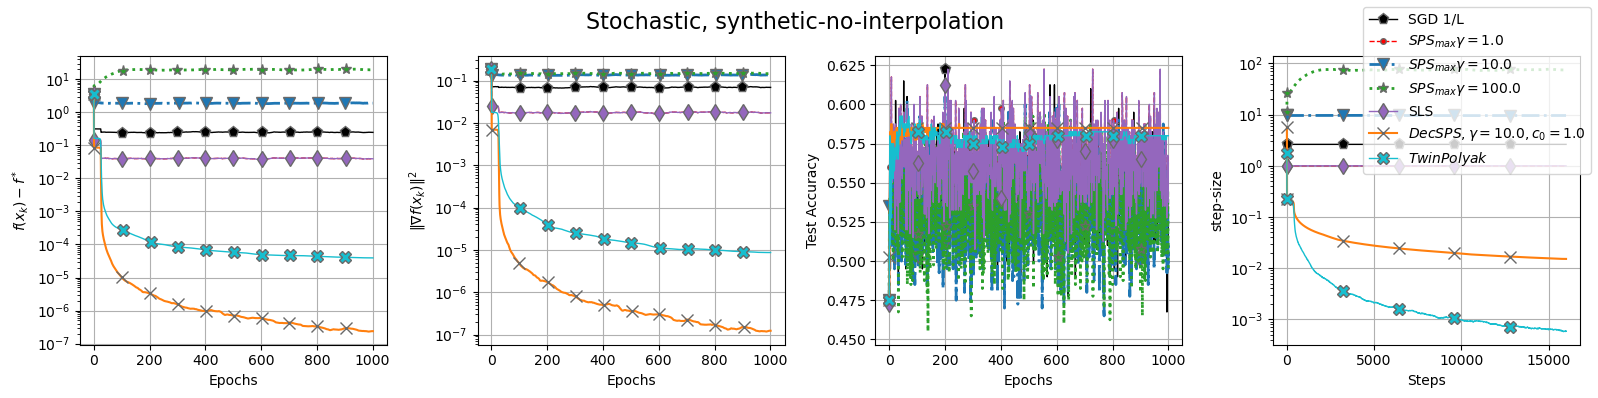

In [79]:
plotter(histories=histories, 
        labels=labels,
        colors=["black", "red", "tab:blue", "tab:green", "tab:purple", "tab:orange", "tab:cyan"],
        linestyles=["-", "--", "-.", ":", "-", "-", "-"],
        linewidths=[1.0, 1.0, 2.0, 2.0, 1.0, 1.5, 1.0],
        markers=["p", ".", "v", "*", "d", "x", "X"],
        markeredgecolor="dimgrey",
        markersize=8,
        alphas=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
        f_star=train_f_star, 
        suptitle=f"{setting}, {dataset_name}",
        prefix="train",
        threshold=0.0,
        apply_ma=True,
        # filename=f"rand_{dataset_name}_{setting.lower()}_logreg.pdf",
        )